In [1]:
from testutils import *
from natsort import natsorted

# Helper functions for visualization.
%matplotlib inline
from IPython.display import HTML
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
pathsims = "/home/tda/CARLA/chrono_scm_newcode/scm_analysis/Outs3"
sims = natsorted(glob.glob(pathsims+"/POLARIS_SCM_scm*"))

dataset = []

for sim in sims:#[:-1]:
    #if "103" not in sim:
    pathsim_ref = sim
    pathsim_nn = sim.replace("POLARIS_SCM_scm","POLARIS_SCM_nn")

    sim_ref = load_sim_soil(pathsim_ref)
    sim_nn = load_sim_soil(pathsim_nn)

    simpair = SimulationPair(sim_ref, sim_nn)

    dataset.append(simpair)

    """
    plot_path(simpair)

    plot_err(simpair)

    plot_pos(simpair, rel_error=True)

    plot_glob(simpair)

    plt.close()
    """

    #emd(simpair)
len(dataset)

/home/tda/CARLA/chrono_scm_newcode/scm_analysis/Outs3/POLARIS_SCM_scm_flat_throttle_1.00_steering_0.00_initheight_0.10_tend_5.00
/home/tda/CARLA/chrono_scm_newcode/scm_analysis/Outs3/POLARIS_SCM_nn_flat_throttle_1.00_steering_0.00_initheight_0.10_tend_5.00


1

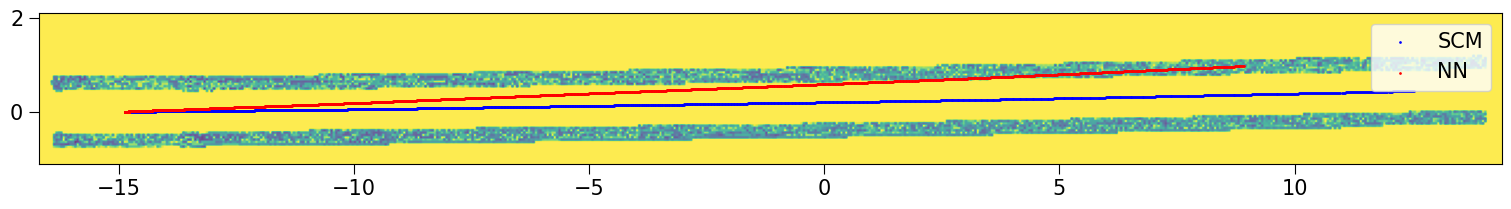

In [3]:
#"""
for simpair in dataset:
    
    plot_path(simpair)
#"""

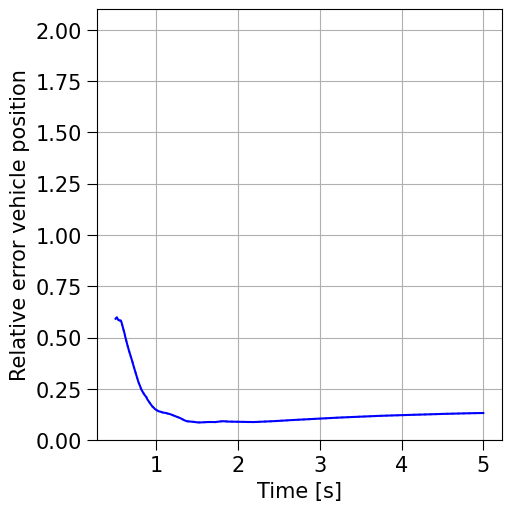

In [4]:
def plot_pos_sims(dataset, rel_error=True):
    
    in_time = 250
    
    err_vec = []
    
    for simpair in dataset:

        wpos_ref, wpos_nn, timevec = simpair.scm.wheelpos, simpair.nn.wheelpos, simpair.timevec

        #print(wpos_ref.shape, wpos_nn.shape)

        vpos_ref, vpos_nn = torch.mean(wpos_ref,dim=0), torch.mean(wpos_nn,dim=0)

        vpos_nn = vpos_nn - vpos_ref[:,0:1]
        vpos_ref = vpos_ref - vpos_ref[:,0:1]

        #length = torch.norm(vpos_ref,dim=0)[1:]
        #length = (get_length(vpos_ref) + get_length(vpos_nn))/2.
        length = get_length(vpos_ref)

        pos_err = torch.norm(vpos_ref - vpos_nn,dim=0)[1:]
        if rel_error:
            pos_err = pos_err/length

        err_vec.append(pos_err.view(1,timevec.shape[0]-1))
        
    err_vec = torch.cat(err_vec,dim=0)
    err_vec = err_vec[:,in_time:]
    timevec = timevec[in_time+1:]
    #print(err_vec.shape)
    
    err_mean, err_std = err_vec.mean(0), err_vec.std(0)
        
    fig, ax = plt.subplots(1,1,figsize=(5,5), constrained_layout=True)
    
    if rel_error:
        ylabel = "Relative error vehicle position"
    else:
        ylabel = "Absolute error vehicle position [m]"

    for i in range(err_vec.shape[0]):
        ax.plot(timevec, err_vec[i],color=col_scm,alpha=0.5,linestyle=":")
        
    ax.plot(timevec, err_mean,color=col_scm)
    ax.fill_between(timevec, err_mean - err_std, err_mean + err_std,color=col_scm,alpha=0.3)
    #ax.plot(timevec[in_time:], length[in_time:],color=col_nn)
    
    ax.grid(which="both")
    ax.set_ylim([0,2.1])
    ax.set_xlabel("Time [s]", fontsize=fontsiz)
    ax.set_ylabel(ylabel, fontsize=fontsiz)
    
    
plot_pos_sims(dataset, rel_error=True)
#plot_pos_sims(dataset, rel_error=False)

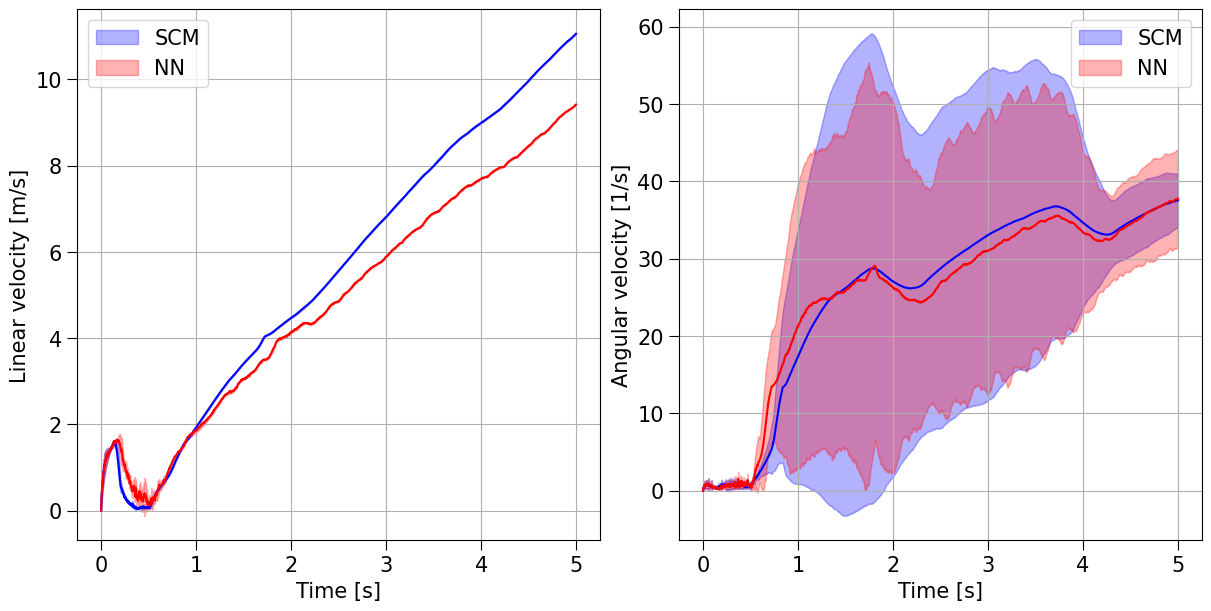

In [5]:
def plot_glob(dataset):
    
    glob_ref_vec, glob_nn_vec = [], []
    
    for simpair in dataset:

        glob_ref, glob_nn, timevec = simpair.scm.glob, simpair.nn.glob, simpair.timevec
    
        globvec_ref = torch.norm(glob_ref[:,:3],dim=1)
        globvec_nn = torch.norm(glob_nn[:,:3],dim=1)
        
        glob_ref_vec.append(globvec_ref); glob_nn_vec.append(globvec_nn)
    
    glob_ref_vec, glob_nn_vec = torch.cat(glob_ref_vec,dim=0), torch.cat(glob_nn_vec,dim=0)
    mean_ref, std_ref = glob_ref_vec.mean(0), glob_ref_vec.std(0)
    mean_nn, std_nn = glob_nn_vec.mean(0), glob_nn_vec.std(0)

    fig, axes = plt.subplots(1,2,figsize=(12,6), constrained_layout=True)

    axes[0].plot(timevec[:mean_ref.shape[0]], mean_ref,color=col_scm)
    axes[0].fill_between(timevec[:mean_ref.shape[0]], mean_ref-std_ref, mean_ref+std_ref,color=col_scm,alpha=0.3, label="SCM")

    axes[0].plot(timevec[:mean_ref.shape[0]], mean_nn,color=col_nn)
    axes[0].fill_between(timevec[:mean_ref.shape[0]], mean_nn-std_nn, mean_nn+std_nn,color=col_nn,alpha=0.3, label="NN")

    axes[0].set_ylabel("Linear velocity [m/s]", fontsize=fontsiz)
    axes[0].set_xlabel("Time [s]", fontsize=fontsiz)
    #axes[0].set_ylim([0.,0.03])
    axes[0].grid(which="both") 
    axes[0].legend()
    
    glob_ref_vec, glob_nn_vec = [], []
    
    for simpair in dataset:

        glob_ref, glob_nn, timevec = simpair.scm.glob, simpair.nn.glob, simpair.timevec
    
        globvec_ref = torch.norm(glob_ref[:,3:6],dim=1)
        globvec_nn = torch.norm(glob_nn[:,3:6],dim=1)
        
        glob_ref_vec.append(globvec_ref); glob_nn_vec.append(globvec_nn)
    
    glob_ref_vec, glob_nn_vec = torch.cat(glob_ref_vec,dim=0), torch.cat(glob_nn_vec,dim=0)
    mean_ref, std_ref = glob_ref_vec.mean(0), glob_ref_vec.std(0)
    mean_nn, std_nn = glob_nn_vec.mean(0), glob_nn_vec.std(0)

    axes[1].plot(timevec[:mean_ref.shape[0]], mean_ref,color=col_scm)
    axes[1].fill_between(timevec[:mean_ref.shape[0]], mean_ref-std_ref, mean_ref+std_ref,color=col_scm,alpha=0.3, label="SCM")
    
    axes[1].plot(timevec[:mean_ref.shape[0]], mean_nn,color=col_nn)
    axes[1].fill_between(timevec[:mean_ref.shape[0]], mean_nn-std_nn, mean_nn+std_nn,color=col_nn,alpha=0.3, label="NN")
    
    axes[1].set_ylabel("Angular velocity [1/s]", fontsize=fontsiz)
    axes[1].set_xlabel("Time [s]", fontsize=fontsiz)
    #axes[0].set_ylim([0.,0.03])
    axes[1].grid(which="both") 
    axes[1].legend()
    
plot_glob(dataset)

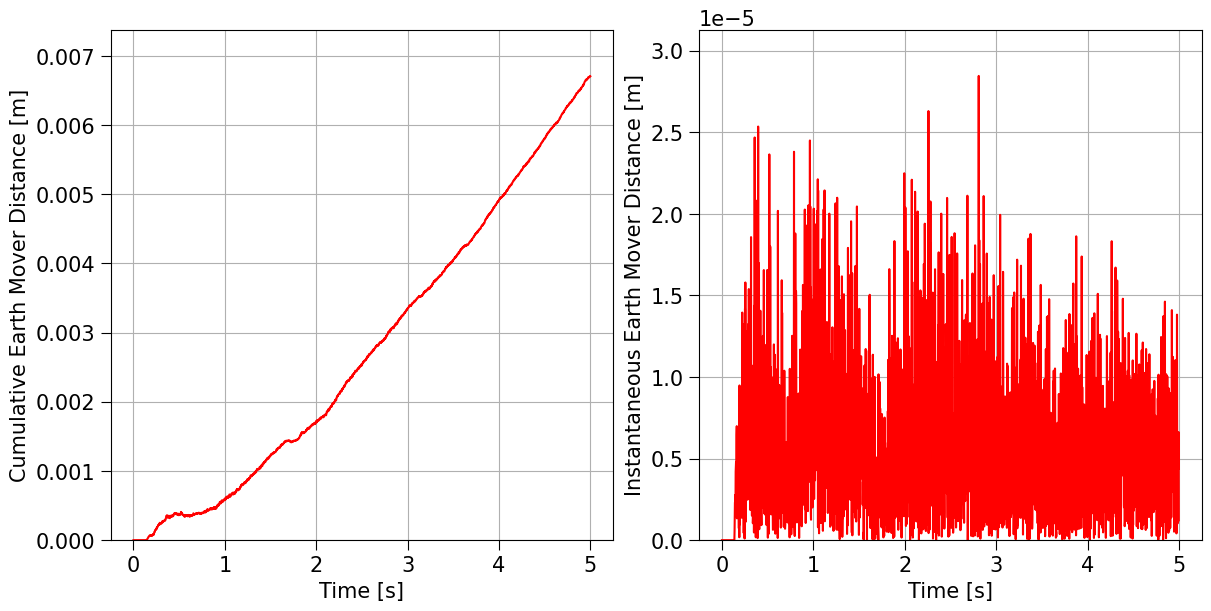

In [17]:
def get_emd_sims(dataset):
    
    emd_vec = []
    
    #timelast = 100
    
    for simpair in dataset:
        
        print(simpair.simname)

        z_ref, z_nn = simpair.scm.soil, simpair.nn.soil
        wheel_ref, wheel_nn = simpair.scm.wheelpos, simpair.nn.wheelpos
        timevec = simpair.timevec#[:timelast]

        """
        indexes_nn = window_filtering(z_nn, wheel_nn)
        indexes_ref = window_filtering(z_ref, wheel_ref)
        #print(z_ref.shape, z_nn.shape, indexes_nn.shape, indexes_ref.shape)
        indexes = torch.logical_or(indexes_nn, indexes_ref)

        x_true = z_ref[indexes]
        x_out = z_nn[indexes]
        """
        
        x_true = z_ref
        x_out = z_nn

        dists = []
        
        for step in range(x_true.shape[2]):
            #for step in range(timelast):

            xtrue, xout = x_true[:,:,step], x_out[:,:,step]

            if xtrue.shape[0]>0:
                wdist = wasserstein_distance(xtrue[:,2], xout[:,2])
            else:
                wdist = 0.

            dists.append(wdist)

        dists = np.array(dists)
        #print(dists.shape)
        
        emd_vec.append( dists.reshape(1,-1) )
    
    emd_vec = np.concatenate(emd_vec,axis=0)
        
    return emd_vec, timevec

"""
def plot_emd_sims(emd_vec, timevec): 
    
    emd_mean, emd_std = emd_vec.mean(0), emd_vec.std(0)

    fig, ax = plt.subplots(1,1,figsize=(5,5), constrained_layout=True)
    
    for i in range(emd_vec.shape[0]):
        ax.plot(timevec, emd_vec[i],color="r",alpha=0.5,linestyle=":")
    
    ax.plot(timevec, emd_mean,color="r")
    ax.fill_between(timevec, emd_mean - emd_std, emd_mean + emd_std,color="r",alpha=0.3)
    
        
    ax.set_ylabel("Earth Mover Distance [m]", fontsize=fontsiz)
    ax.set_xlabel("Time [ms]", fontsize=fontsiz)
    #ax.set_yscale("log")
    #ax.set_ylim([1.e-4,1.e-1])
    ax.grid(which="both")
"""

def plot_emd_sims(err_vec, timevec, typeplot="abs"): 
    
    if typeplot=="abs":
        namequant = "absolute error in height [m]"
    elif typeplot=="emd":
        namequant = "Earth Mover Distance [m]"
    
    if not torch.is_tensor(err_vec):
        err_vec = torch.tensor(err_vec)
    
    fig, axes = plt.subplots(1,2,figsize=(12,6), constrained_layout=True)
    
    # Cumulative error
    mean_err, std_err = err_vec.mean(0), err_vec.std(0)

    axes[0].plot(timevec, mean_err,color="r")
    axes[0].fill_between(timevec, mean_err-std_err, mean_err+std_err,color="r",alpha=0.3)
    
    axes[0].set_ylabel("Cumulative "+namequant, fontsize=fontsiz)
    axes[0].set_xlabel("Time [s]", fontsize=fontsiz)
    limy = (mean_err+std_err).max()*1.1
    if np.isnan(limy): limy = mean_err.max()*1.1
    axes[0].set_ylim([0.,limy])
    axes[0].grid(which="both") 
    
    # Step error
    soil_abs_err = torch.abs(err_vec[:,1:] - err_vec[:,:-1])
    mean_err, std_err = soil_abs_err.mean(0), soil_abs_err.std(0)

    axes[1].plot(timevec[:-1], mean_err,color="r")
    axes[1].fill_between(timevec[:-1], mean_err-std_err, mean_err+std_err,color="r",alpha=0.3)

    axes[1].set_ylabel("Instantaneous "+namequant, fontsize=fontsiz)
    axes[1].set_xlabel("Time [s]", fontsize=fontsiz)
    limy = (mean_err+std_err).max()*1.1
    if np.isnan(limy): limy = mean_err.max()*1.1
    axes[1].set_ylim([0.,limy])
    axes[1].grid(which="both")  

emd_vec, timevec = get_emd_sims(dataset)
np.save("emd_array",emd_vec)
emd_vec = np.load("emd_array.npy")
plot_emd_sims(emd_vec, dataset[0].timevec, typeplot="emd")

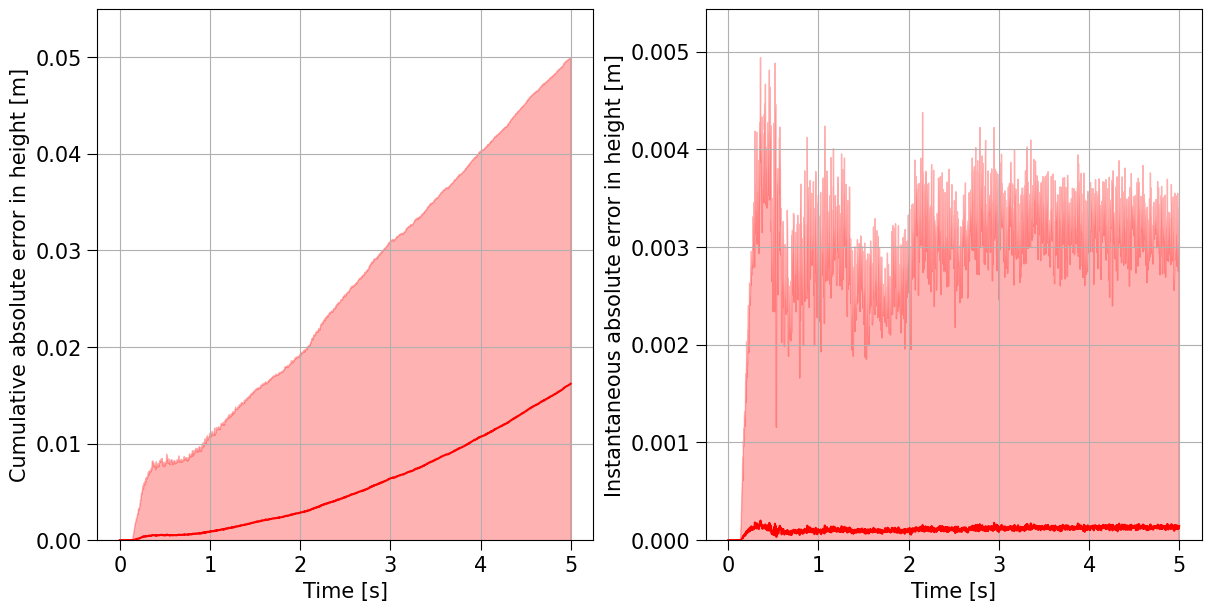

In [18]:
def plot_err_sims(dataset):
    
    err_vec = []
    
    for simpair in dataset:
        
        print(simpair.simname)

        z_ref, z_nn = simpair.scm.soil, simpair.nn.soil
        wheel_ref, wheel_nn = simpair.scm.wheelpos, simpair.nn.wheelpos

        """
        indexes_ref = window_filtering(z_ref, wheel_ref)
        indexes_nn = window_filtering(z_nn, wheel_nn)
        indexes = torch.logical_or(indexes_nn, indexes_ref)

        z_ref = z_ref[indexes]
        z_nn = z_nn[indexes]
        """

        z_ref, z_nn = z_ref[:,2], z_nn[:,2]
    
        soil_abs_err = torch.abs(z_ref - z_nn)
        
        err_vec.append(soil_abs_err)
        
    err_vec = torch.cat(err_vec,dim=0)
    
    return err_vec
    
"""
    limy = 0.06

    fig, axes = plt.subplots(1,2,figsize=(12,6), constrained_layout=True)
    
    # Cumulative error
    mean_err, std_err = err_vec.mean(0), err_vec.std(0)

    timevec = simpair.timevec

    axes[0].plot(timevec, mean_err,color="r")
    axes[0].fill_between(timevec, mean_err-std_err, mean_err+std_err,color="r",alpha=0.3)
    
    axes[0].set_ylabel("Cumulative absolute error in height [m]", fontsize=fontsiz)
    axes[0].set_xlabel("Time [s]", fontsize=fontsiz)
    axes[0].set_ylim([0.,limy])
    axes[0].grid(which="both") 
    
    # Step error
    soil_abs_err = torch.abs(err_vec[1:] - err_vec[:-1])
    mean_err, std_err = err_vec.mean(0), err_vec.std(0)

    timevec = np.array(range(soil_abs_err.shape[-1]))*dt

    axes[1].plot(timevec, mean_err,color="r")
    axes[1].fill_between(timevec, mean_err-std_err, mean_err+std_err,color="r",alpha=0.3)

    axes[1].set_ylabel("Instantaneous absolute error in height [m]", fontsize=fontsiz)
    axes[1].set_xlabel("Time [s]", fontsize=fontsiz)
    axes[1].set_ylim([0.,limy])
    axes[1].grid(which="both")  
"""   

#plot_err_sims(dataset)
err_vec = plot_err_sims(dataset)
plot_emd_sims(err_vec, dataset[0].timevec, typeplot="abs")